In [1]:
import random
import time
import os

from IPython.display import clear_output

import torch
from torch import nn, optim, cuda
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
BS = 32

In [2]:
device = 'cpu'
if cuda.is_available():
    device_name = cuda.get_device_name(0)
    memory = cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"Device {device_name} has {memory} GB of memory")
    device = torch.device('cuda')
else:
    raise Exception("Cuda isn't available")
device

Device NVIDIA GeForce RTX 3060 Ti has 7.9993896484375 GB of memory


device(type='cuda')

In [3]:
transform = transforms.Compose([
    # transforms.Resize([100, 100]),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomResizedCrop(224),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = datasets.ImageFolder(root='./dataset/tr', transform=transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=transform)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [5]:
try:
  if model:
    model.zero_grad()
    del model
    torch.cuda.empty_cache()
    print('model has been deleted')
except:
  print('model doesnt exist')

model doesnt exist


In [6]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 2),
)
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 2),
# )

model = model.to(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)
num_epochs = 50
#lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

len_loader = len(train_loader)

accuracy = torchmetrics.Accuracy(task='binary').to(device)
precision = torchmetrics.Precision(task='binary').to(device)
recall = torchmetrics.Recall(task='binary').to(device)
f1 = torchmetrics.F1Score(task='binary').to(device)

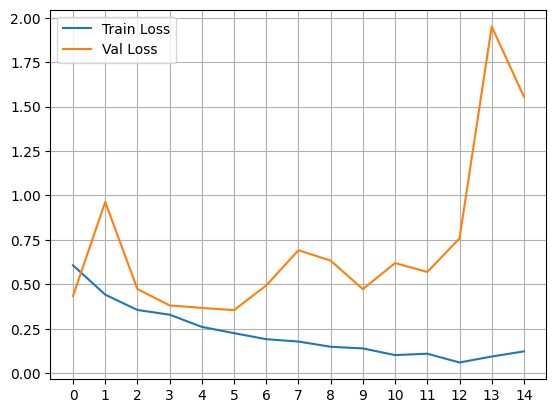

[0.6067841319423734, 0.4415739174142028, 0.3553175146155285, 0.32877255095676944, 0.26011261705196265, 0.224716895739689, 0.1908363528323896, 0.17751891261926203, 0.1481309047984806, 0.13889946967758465, 0.10119910258094245, 0.10910791909378587, 0.0597114616609884, 0.09323981447342897, 0.12220009450208057]
[0.43401764924156255, 0.963353656232357, 0.47298012519704885, 0.38097755668749067, 0.3670710016941202, 0.3543293234282013, 0.4936438611355321, 0.6917870918224598, 0.6331085579405571, 0.47253059269057524, 0.6194188249425898, 0.5692848427028492, 0.7581913296496074, 1.9513989317006077, 1.5558970087520971]
tensor(0.7877, device='cuda:0')
Epoch: 15 / 50
 Train batch 34/66

KeyboardInterrupt: 

In [8]:
x_vals = []
train_losses = []
val_losses = []


runs_dir = "runs_2class"
os.makedirs(runs_dir, exist_ok=True)
existing_runs = [d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]


if existing_runs:
    max_index = max([int(d.split("run")[1]) for d in existing_runs])
    new_run_index = max_index + 1
else:
    new_run_index = 1

current_run_dir = os.path.join(runs_dir, f"run{new_run_index}")
os.makedirs(current_run_dir, exist_ok=True)

train_stats_file = os.path.join(current_run_dir, "train_stats.txt")
test_stats_file = os.path.join(current_run_dir, "test_stats.txt")
best_model_weights_file = os.path.join(current_run_dir, "best.pth")

with open(train_stats_file, 'w') as f:
    f.write(f"{model.__class__.__name__} for {num_epochs} epochs\n")

best_val_loss = float('inf')
best_val_accuracy = 0.0
best_epoch = 0


start = time.time()
for epoch in range(num_epochs):
    print(f'\rEpoch: {epoch} / {num_epochs}')
    x_vals.append(epoch)
    model.train()
    i = 1
    running_loss = 0.0
    val_running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\r Train batch {batch_idx}/{len(train_loader)}", end='', flush=True)
        # if i % 10 == 0:
            # print(f'\rIteration: {i} / {len_loader}', end='', flush=True)
        i += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # print(f"Outputs {outputs}")
        # print(predicted)
        # print("_______________LABELS_______________")
        # print(labels)
        # print(f"labels: {labels}\nrped: {predicted}")
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    # print(f"\nTrain loss: {epoch_train_loss}")
    print('\n')


    # lr_scheduler.step()
    model.eval()

    acc_sum = 0
    pres_sum = 0
    recall_sum = 0
    f1_sum = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            print(f"\r Val batch {batch_idx}/{len(val_loader)}", end='', flush=True)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # print(predicted)
            # print("_______________LABELS_______________")
            # print(labels)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            # print(f"Outputs {outputs}")
            # print(f"labels: {labels}\nrped: {predicted}")
            # print(f"Labels: {val_labels}\n Predicted: {predicted}")

            # print(f"len labels {len(labels)} len out {len(outputs)} len pred {len(predicted)}")
            # print(f"labels:\n{val_labels}\npred:\n{predicted}")
            accuracy.update(predicted, labels)
            # acc_sum += accuracy(predicted, labels)
            # pres_sum += precision(outputs, labels)
            # recall_sum += recall(outputs, labels)
            # f1_sum += f1(outputs, labels)

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_acc = accuracy.compute()


        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_weights_file)
            dur = time.time() - start
            with open(train_stats_file, "a") as f:
                f.write(f"Epoch {epoch + 1} / {num_epochs}: Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_acc} Dur: {dur} Dur/Epoch: {dur / epoch if epoch != 0 else 0}\n")
        elif epoch > best_epoch + 25:
            break


        clear_output(wait=True)
        # plt.figure(figsize=(2, 2))
        plt.plot(x_vals, train_losses, label='Train Loss')
        plt.plot(x_vals, val_losses, label='Val Loss')
        plt.legend()
        plt.grid(True)
        plt.xticks(x_vals, x_vals)
        plt.show()

        print(train_losses)
        print(val_losses)
        print(val_acc)

In [ ]:
model.load_state_dict(torch.load(best_model_weights_file))
model = model.to(device)
model = model.to(device)

model.eval()
accuracy = torchmetrics.Accuracy(task='binary').to(device)
precision = torchmetrics.Precision(task='binary').to(device)
recall = torchmetrics.Recall(task='binary').to(device)
f1 = torchmetrics.F1Score(task='binary').to(device)

val_running_loss = 0.0

with torch.no_grad():
  for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"\rBatch {batch_idx}/{len(test_loader)}", end='', flush=True)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1).float())
    running_loss += loss.item()

    # print(f"Outputs {outputs}")
    predicted = (outputs > 0.5).float().squeeze().to(device)
    # print(f"labels: {labels}\nrped: {predicted}")
    # print(f"Labels: {val_labels}\n Predicted: {predicted}")

    # print(f"len labels {len(labels)} len out {len(outputs)} len pred {len(predicted)}")
    # print(f"labels:\n{val_labels}\npred:\n{predicted}")
    accuracy.update(predicted, labels)
    precision.update(predicted, labels)
    recall.update(predicted, labels)
    f1.update(predicted, labels)
  test_loss = val_running_loss / len(test_loader)
  test_acc = accuracy.compute()
  test_pres = precision.compute()
  test_rec = recall.compute()
  test_f1 = f1.compute()

res_str = f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_pres:.4f}, Test Recall: {test_rec:.4f}, Test F1-score: {test_f1:.4f}"
print(res_str)
with open(test_stats_file, "w") as f:
  f.write(res_str)

model has been deleted


RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "fc.3.weight", "fc.3.bias". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([1, 2048]).
	size mismatch for fc.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
#10 epochs: Test Loss: 0.2050, Test Accuracy: 0.9193, Test Precision: 0.5031, Test Recall: 0.4503, Test F1-score: 0.4696
#50 epochs: Test Loss: 0.2354, Test Accuracy: 0.9022, Test Precision: 0.5031, Test Recall: 0.4379, Test F1-score: 0.4616